In [ ]:
import torch
from torch.functional import F

gate = torch.nn.Linear(768, 60, bias=False)

hidden_states = torch.randn(12, 128, 768)
batch_size, sequence_length, hidden_dim = hidden_states.shape
hidden_states = hidden_states.view(-1, hidden_dim)
router_logits = gate(hidden_states)

routing_weights = F.softmax(router_logits, dim=1, dtype=torch.float)
routing_weights, selected_experts = torch.topk(routing_weights, 4, dim=-1)

final_hidden_states = torch.zeros(
            (batch_size * sequence_length, hidden_dim), dtype=hidden_states.dtype, device=hidden_states.device
        )
expert_mask = torch.nn.functional.one_hot(selected_experts, num_classes=60).permute(2, 1, 0)
print(selected_experts)


In [ ]:
import torch
hidden_states = torch.randn(2,128,768)
# hidden_states = hidden_states.view(-1, 768)
gate = torch.nn.Linear(768, 2, bias=False)


x = gate(hidden_states).mean(dim=1)

group_labels = torch.argmax(x, dim=-1)

print(group_labels)

# 根据分组标签创建索引列表
groups = [[] for _ in range(2)]
for i, label in enumerate(group_labels):
    groups[label.item()].append(i)

print(groups[0])
print(groups[1])

# 分别对每组进行独立处理并记录原始索引
processed_groups = []
original_indices = []
for group in groups:
    if len(group) == 0:

        continue
    group_tensor = hidden_states[torch.tensor(group, dtype=torch.long)]
    processed_group = group_tensor.clone()  # 替换为实际的处理方法
    processed_groups.append(processed_group)
    original_indices.extend(group)

combined = torch.cat(processed_groups, dim=0)
gate_logits = torch.randn(2*128,768)
# 基于原始索引排序以恢复顺序
original_indices = torch.tensor(original_indices)
print(original_indices)
sorted_indices = torch.argsort(original_indices)
print(sorted_indices)
reordered_combined = combined[sorted_indices]
print(gate_logits.shape)
gate_logits = gate_logits.reshape(-1, 768)
torch.equal(hidden_states, reordered_combined)


In [ ]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
from transformers import AutoTokenizer, Qwen2TokenizerFast
tokenizer = AutoTokenizer.from_pretrained('Qwen/CodeQwen1.5-7B-Chat')
# tokenizer = AutoTokenizer.from_pretrained('microsoft/Phi-3-small-8k-instruct', truste_remote=True)


In [ ]:
conversations = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Who are you"}
]

# TEMPLATE="{% for message in messages %}{% if loop.first and messages[0]['role'] != 'system' %}{{ '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n' }}{% endif %}{{'<|im_start|>' + message['role'] + '\n' + message['content']}}{% if loop.last %}{{ '<|im_end|>'}}{% else %}{{ '<|im_end|>\n' }}{% endif %}{% endfor %}"

text = tokenizer.apply_chat_template(
        conversations,
        tokenize=False,
        add_generation_prompt=True
    )
print(text)


In [ ]:
import torch
from datasets import load_dataset

train_data = load_dataset('json', data_files='/Users/jachinlin/Documents/Code/QwenSQL-MoE/data/merge_output/0725/train_mysql_pg_cypher_ngql.json')['train']
train_data = train_data.select(range(10))
print(train_data[0])
print(train_data)

TEMPLATE="{% for message in messages %}{% if loop.first and messages[0]['from'] != 'system' %}{{ '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n' }}{% endif %}{{'<|im_start|>' + message['from'] + '\n' + message['value']}}{% if loop.last %}{{ '<|im_end|>'}}{% else %}{{ '<|im_end|>\n' }}{% endif %}{% endfor %}"

def process_data(example):
    conversations = example['conversations']
    text = tokenizer.apply_chat_template(
        conversations,
        # chat_template=TEMPLATE,
        tokenize=False,
        add_generation_prompt=False
    )

    prompt_part = tokenizer.apply_chat_template(
        conversations[:1],
        # chat_template=TEMPLATE,
        tokenize=False,
        add_generation_prompt=True
    )

    encodings = tokenizer(text)
    target_idx = len(tokenizer(prompt_part)['input_ids'])
    
    labels = encodings['input_ids'].copy()
    labels[:target_idx] = [-100]*target_idx
    encodings['labels'] = labels
    print(labels)
    assert len(labels) == len(encodings['input_ids'])
    return None
    

train_data = train_data.map(process_data, num_proc=1)

print(train_data)



In [ ]:
input = """hello<|im_start|>assistant
SELECT `球员姓名`, `身高` FROM `球员夺冠次数` AS `T1` JOIN `羽毛球球员` AS `T2` ON `T1`.`球员id` = `T2`.`球员id` JOIN `重要赛事` AS `T3` ON `T1`.`赛事id` = `T3`.`赛事id` WHERE `赛事名称` = '苏迪曼杯' ORDER BY `身高` DESC<|im_end|>"""
encodings = tokenizer.encode_plus(input, return_tensors='pt')

# print(encodings)

idx = input.find("""sada
SELECT `球员姓名`, `身高` FROM `球员夺冠次数` AS `T1` JOIN `羽毛球球员` AS `T2` ON `T1`.`球员id` = `T2`.`球员id` JOIN `重要赛事` AS `T3` ON `T1`.`赛事id` = `T3`.`赛事id` WHERE `赛事名称` = '苏迪曼杯' ORDER BY `身高` DESC""")
labels = encodings['input_ids'].clone().squeeze()

target_idx = encodings.char_to_token(idx)

labels[:target_idx] = -100

labels

In [ ]:
import torch


def load_balancing_loss_func(
    gate_logits, num_experts = None, top_k=2, attention_mask = None
) -> float:
    r"""
    Computes auxiliary load balancing loss as in Switch Transformer - implemented in Pytorch.

    See Switch Transformer (https://arxiv.org/abs/2101.03961) for more details. This function implements the loss
    function presented in equations (4) - (6) of the paper. It aims at penalizing cases where the routing between
    experts is too unbalanced.

    Args:
        gate_logits (Union[`torch.Tensor`, Tuple[torch.Tensor]):
            Logits from the `gate`, should be a tuple of model.config.num_hidden_layers tensors of
            shape [batch_size X sequence_length, num_experts].
        attention_mask (`torch.Tensor`, None):
            The attention_mask used in forward function
            shape [batch_size X sequence_length] if not None.
        num_experts (`int`, *optional*):
            Number of experts

    Returns:
        The auxiliary loss.
    """
    if gate_logits is None or not isinstance(gate_logits, tuple):
        return 0

    if isinstance(gate_logits, tuple):
        compute_device = gate_logits[0].device
        concatenated_gate_logits = torch.cat([layer_gate.to(compute_device) for layer_gate in gate_logits], dim=0)

    

    routing_weights = torch.nn.functional.softmax(concatenated_gate_logits, dim=-1)

    _, selected_experts = torch.topk(routing_weights, top_k, dim=-1)

    expert_mask = torch.nn.functional.one_hot(selected_experts, num_experts)
    if attention_mask is None:
        # Compute the percentage of tokens routed to each experts
        tokens_per_expert = torch.mean(expert_mask.float(), dim=0)
        # Compute the average probability of routing to these experts
        router_prob_per_expert = torch.mean(routing_weights, dim=0)
    else:
        batch_size, sequence_length = attention_mask.shape
        num_hidden_layers = concatenated_gate_logits.shape[0] // (batch_size * sequence_length)
        # Compute the mask that masks all padding tokens as 0 with the same shape of expert_mask

        expert_attention_mask = (
            attention_mask[None, :, :, None, None]
            .expand((num_hidden_layers, batch_size, sequence_length, top_k, num_experts))
            .reshape(-1, top_k, num_experts)
            .to(compute_device)
        )
        # Compute the percentage of tokens routed to each experts
        tokens_per_expert = torch.sum(expert_mask.float() * expert_attention_mask, dim=0) / torch.sum(
            expert_attention_mask, dim=0
        )

        # Compute the mask that masks all padding tokens as 0 with the same shape of tokens_per_expert
        router_per_expert_attention_mask = (
            attention_mask[None, :, :, None]
            .expand((num_hidden_layers, batch_size, sequence_length, num_experts))
            .reshape(-1, num_experts)
            .to(compute_device)
        )
        print(router_per_expert_attention_mask)
        print(routing_weights.shape)
        # Compute the average probability of routing to these experts
        router_prob_per_expert = torch.sum(routing_weights * router_per_expert_attention_mask, dim=0) / torch.sum(
            router_per_expert_attention_mask, dim=0
        )
        print(router_prob_per_expert)

    overall_loss = torch.sum(tokens_per_expert * router_prob_per_expert.unsqueeze(0))
    return overall_loss * num_experts

# gate_logits = 
gate_logits=()
for i in range(24):
    gate_logits+=(torch.randn(2*8, 12),)
attention_mask = torch.ones(2, 8)
# attention_mask = torch.ones(1, 4)
attention_mask[1][4:] = 0

# print(load_balancing_loss_func(gate_logits=gate_logits, num_experts=12, attention_mask=attention_mask))

print(load_balancing_loss_func(gate_logits=gate_logits, num_experts=12))

In [ ]:
concatenated_gate_logits = torch.randn(1*3,8)
attention_mask = torch.ones(1, 3)
print(attention_mask)
routing_weights = torch.nn.functional.softmax(concatenated_gate_logits, dim=-1)

print(routing_weights)
t, selected_experts = torch.topk(routing_weights, 4, dim=-1)

print(t, t.shape)
print(selected_experts, selected_experts.shape)


expert_mask = torch.nn.functional.one_hot(selected_experts, 8)
print(expert_mask)

tokens_per_expert = torch.mean(expert_mask.float(), dim=0)
router_prob_per_expert = torch.mean(routing_weights, dim=0)

print(tokens_per_expert)
print(router_prob_per_expert)


overall_loss = torch.sum(tokens_per_expert * router_prob_per_expert)

print(torch.sum(tokens_per_expert * router_prob_per_expert.unsqueeze(0)))

overall_loss

In [ ]:
import torch
attention_mask = torch.randn(4, 10)
t = torch.randn(4, 10)
seqlens_in_batch = attention_mask.sum(dim=-1, dtype=torch.int32)
seqlens_in_batch.dtype
indices = torch.nonzero(attention_mask.flatten(), as_tuple=False).flatten()

t[indices[0]]

In [ ]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
os.environ['HF_HOME'] = '/mnt/data/ckpt/linzhisheng/cache'
os.environ['MODELSCOPE_CACHE'] = '/mnt/data/ckpt/linzhisheng/modelscope_cache'
import torch
from transformers import AutoModelForCausalLM
from model.modeling_qwen2_moe import Qwen2MoeForCausalLM
from peft import PeftModel
# model = AutoModelForCausalLM.from_pretrained('deepseek-ai/DeepSeek-Coder-V2-Lite-Instruct', trust_remote_code=True)

# model = Qwen2MoeForCausalLM.from_pretrained('Qwen/Qwen1.5-MoE-A2.7B-Chat')

base_model = AutoModelForCausalLM.from_pretrained('Qwen/Qwen1.5-32B-Chat', torch_dtype=torch.float16, attn_implementation="flash_attention_2")
peft_model_id = "output/dense/0624/qwen2_32b_lora_no_shuffle_1e-6_question/checkpoint-500"
model = PeftModel.from_pretrained(base_model, peft_model_id, torch_dtype=torch.float16, attn_implementation="flash_attention_2")

model = model.merge_and_unload()
model.save_pretrained("output/dense/0624/qwen2_32b_lora_no_shuffle_1e-6_question/merge")

# model = AutoModelForCausalLM.from_pretrained('model/deepseek-ai/DeepSeek-Coder-V2-Lite-Instruct', trust_remote_code=True, torch_dtype=torch.bfloat16)
# #模型下载
# from modelscope import snapshot_download
# model_dir = snapshot_download('deepseek-ai/DeepSeek-Coder-V2-Lite-Instruct')


In [ ]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('defog/llama-3-sqlcoder-8b')

In [ ]:
conversations = [
    {"role": "user", "content": "Who are you"},
    {"role": "assistant", "content": "The following SQL query best answers the question"}
]
text = tokenizer.apply_chat_template(
        conversations,
        tokenize=False,
        add_generation_prompt=False
    )
print(text)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class ExpertGroup(nn.Module):
    def __init__(self, num_experts):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = 2
        self.norm_topk_prob = False
        
        self.experts = nn.ModuleList(
            [nn.Linear(2048, 2048) for _ in range(self.num_experts)]
        )
        self.gate = nn.Linear(2048, self.num_experts, bias=False)
        
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        batch_size, sequence_length, hidden_dim = hidden_states.shape
        hidden_states = hidden_states.view(-1, hidden_dim)
        # router_logits: (batch * sequence_length, n_experts)
        router_logits = self.gate(hidden_states)

        routing_weights = F.softmax(router_logits, dim=1, dtype=torch.float)
        routing_weights, selected_experts = torch.topk(routing_weights, self.top_k, dim=-1, sorted=False)

        if self.norm_topk_prob:
            routing_weights /= routing_weights.sum(dim=-1, keepdim=True)
        # we cast back to the input dtype
        routing_weights = routing_weights.to(hidden_states.dtype)
        flat_topk_idx = selected_experts.view(-1)

        
        if 0 and self.training:
            hidden_states = hidden_states.repeat_interleave(
                self.top_k, dim=0
            )

            y = torch.empty_like(hidden_states)
            
            for i, expert in enumerate(self.experts):
                y[flat_topk_idx == i] = expert(hidden_states[flat_topk_idx == i])
            y = (y.view(*routing_weights.shape, -1) * routing_weights.unsqueeze(-1)).sum(dim=1)
        else:
            y = self.moe_infer(hidden_states, selected_experts, routing_weights)
        y = y.reshape(batch_size, sequence_length, hidden_dim)
        

        router_logits = router_logits.reshape(batch_size, sequence_length, self.num_experts)
        return y, router_logits
    
    @torch.no_grad()
    def moe_infer(self, x, topk_ids, topk_weight):
        cnts = topk_ids.new_zeros((topk_ids.shape[0], len(self.experts)))
        cnts.scatter_(1, topk_ids, 1)
        tokens_per_expert = cnts.sum(dim=0)
        # print(topk_ids)
        idxs = topk_ids.view(-1).argsort()
        print(x.shape)
        # print((idxs // topk_ids.shape[1]).shape)
        sorted_tokens = x[idxs // topk_ids.shape[1]]
        sorted_tokens_shape = sorted_tokens.shape
        print(sorted_tokens_shape)

        tokens_per_expert = tokens_per_expert.cpu().numpy()
        outputs = []
        start_idx = 0
        for i, num_tokens in enumerate(tokens_per_expert):
            end_idx = start_idx + num_tokens
            if num_tokens == 0:
                continue
            expert = self.experts[i]
            tokens_for_this_expert = sorted_tokens[start_idx:end_idx]
            expert_out = expert(tokens_for_this_expert)
            outputs.append(expert_out)
            start_idx = end_idx

        outs = torch.cat(outputs, dim=0) if len(outputs) else sorted_tokens.new_empty(0)

        new_x = torch.empty_like(outs)
        new_x[idxs] = outs
        final_out = (
            new_x.view(*topk_ids.shape, -1)
            .type(topk_weight.dtype)
            .mul_(topk_weight.unsqueeze(dim=-1))
            .sum(dim=1)
            .type(new_x.dtype)
        )
        return final_out


exceptGroup = ExpertGroup(12)

hidden_states = torch.randn(2, 64, 2048)

res = exceptGroup.forward(hidden_states)

base = torch.nn.Linear()
# print(res[0])
# print(res[2])

In [ ]:
str(100 * round(145 / 304,5))

In [ ]:
import sys
sys.path.append('../../')
from utils.common_utils import read_json, write_json

data = read_json('/Users/jachinlin/Documents/Code/QwenSQL-MoE/data/merge_output/0628/test_eval_PGOnlineTeamv1_20240627.json')
data[0]
format_data = []
for i,row in enumerate(data):
    # row['prompt'] = row['prompt'].replace('【SQL】', 'sql')
    # row['prompt'] = row['prompt'][:-3] + '```sql'

    conversation = [
        {
            "role": "user",
            "content": row['prompt']
        },
        {
            "role": "assistant",
            "content": row["sql"]
        }
    ]
    train_item = {
        "id": i,
        "conversations": conversation,
        "db_name": row['db_name']
    }
    format_data.append(train_item)
    
write_json('../../data/merge_output/0708/sql_eval_bruce.json', format_data)

In [ ]:
import sys
sys.path.append('../')
import torch
from trainer.moe import LoRALayer
import math
import torch.nn as nn
import torch.nn.functional as F
class MoELinear(nn.Linear, LoRALayer):
    # LoRA implemented in a dense layer
    def __init__(
        self, 
        config,
        in_features: int, 
        out_features: int, 
        r: int = 0, 
        lora_alpha: int = 1, 
        lora_dropout: float = 0.,
        fan_in_fan_out: bool = False, # Set this to True if the layer to replace stores weight like (fan_in, fan_out)
        merge_weights: bool = True,
        **kwargs
    ):
        nn.Linear.__init__(self, 1, 1, **kwargs)
        LoRALayer.__init__(self, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout,
                           merge_weights=merge_weights)

        self.fan_in_fan_out = fan_in_fan_out
        self.num_experts = config.num_experts
        self.lora_route_type = config.lora_route_type
        self.top_k = config.num_experts_per_tok
        self.dialect_num = config.dialect_num
        self.enable_dialect_router = config.enable_dialect_router
        self.in_features = in_features
        self.out_features = out_features
        # Actual trainable parameters
        if r > 0:
            if self.num_experts == 1:
                self.lora_A = nn.Parameter(self.weight.new_zeros((r, in_features), dtype=torch.bfloat16))
                self.lora_B = nn.Parameter(self.weight.new_zeros((out_features, r), dtype=torch.bfloat16))
            else:
                self.lora_A = nn.ParameterList()
                self.lora_B = nn.ParameterList()
                for _ in range(self.num_experts):
                    self.lora_A.append(nn.Parameter(self.weight.new_zeros((r, in_features), dtype=torch.bfloat16)))
                    self.lora_B.append(nn.Parameter(self.weight.new_zeros((out_features, r), dtype=torch.bfloat16)))
                self.lora_moe_gate = nn.Parameter(torch.zeros(in_features, self.num_experts, dtype=torch.bfloat16), requires_grad=True)
                
                self.temperature = 1
                self.softmax = nn.Softmax(dim=-1)
                if self.enable_dialect_router:
                    # sql dialects
                    self.dialect_gate = nn.Parameter(torch.zeros(in_features, self.dialect_num, dtype=torch.bfloat16), requires_grad=True)

            self.scaling = self.lora_alpha / self.r
            # Freezing the pre-trained weight matrix
            self.weight.requires_grad = False
        self.reset_parameters()
        if fan_in_fan_out:
            self.weight.data = self.weight.data.transpose(0, 1)

    def reset_parameters(self):
        nn.Linear.reset_parameters(self)
        if hasattr(self, 'lora_A'):
            # initialize B the same way as the default for nn.Linear and A to zero
            # this is different than what is described in the paper but should not affect performance
            if self.num_experts == 1:
                nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
                nn.init.zeros_(self.lora_B)
            else:
                for i in range(self.num_experts):
                    nn.init.kaiming_uniform_(self.lora_A[i], a=math.sqrt(5))
                    nn.init.zeros_(self.lora_B[i])
        if hasattr(self, 'lora_moe_gate'):
            nn.init.kaiming_uniform_(self.lora_moe_gate, a=math.sqrt(5))

        if hasattr(self, 'dialect_gate'):
            nn.init.kaiming_uniform_(self.dialect_gate, a=math.sqrt(5))

    def train(self, mode: bool = True):
        def T(w):
            return w.transpose(0, 1) if self.fan_in_fan_out else w
        nn.Linear.train(self, mode)
        if mode:
            if self.merge_weights and self.merged and self.num_experts == 1:
                # Make sure that the weights are not merged
                if self.r > 0:
                    self.weight.data -= T(self.lora_B @ self.lora_A) * self.scaling
                self.merged = False
        else:
            if self.merge_weights and not self.merged and self.num_experts == 1:
                # Merge the weights and mark it
                if self.r > 0:
                    self.weight.data += T(self.lora_B @ self.lora_A) * self.scaling
                self.merged = True       

    def forward(self, x: torch.Tensor):
        def T(w):
            return w.transpose(0, 1) if self.fan_in_fan_out else w
        if self.r > 0 and not self.merged:
            result = F.linear(x, T(self.weight), bias=self.bias)
            router_logits = None
            if self.num_experts == 1:        
                result += (self.lora_dropout(x) @ self.lora_A.transpose(0, 1) @ self.lora_B.transpose(0, 1)) * self.scaling
            else:
                if self.lora_route_type == 'sentence':
                    gate_x = x.mean(1).unsqueeze(1)
                    gete_out = gate_x @ self.lora_moe_gate
                    gating_weights = self.softmax(gete_out/self.temperature)
                    all_results = []
                    x = self.lora_dropout(x)
                    for i in range(self.num_experts):
                        all_results.append((x @ self.lora_A[i].transpose(0, 1) @ self.lora_B[i].transpose(0, 1)) * self.scaling)
                    final_output = torch.stack(all_results, dim=3) @ gating_weights.unsqueeze(3)
                    final_output = final_output.squeeze()
                    if len(final_output.shape) == 2:
                        final_output = final_output.unsqueeze(0)
                    result += final_output
                elif self.lora_route_type == 'token':
                    batch_size, sequence_length, hidden_dim = x.shape
                    x = x.view(-1, hidden_dim)

                    router_logits = x @ self.lora_moe_gate
                    routing_weights = F.softmax(router_logits, dim=1, dtype=torch.float)
                    if self.enable_dialect_router:
                        # token level dialect
                        dialect_logits = x @ self.dialect_gate
                        dialect_weights = F.softmax(dialect_logits, dim=1, dtype=torch.float)


                        num_experts_per_group = self.num_experts // self.dialect_num
                    

                        routing_weights = routing_weights.view(-1, self.dialect_num, num_experts_per_group) * dialect_weights.unsqueeze(2)
                        routing_weights = routing_weights.view(-1, self.num_experts)

                    # print(router_logits[0])


                    
                    # print(routing_weights[0])

                    routing_weights, selected_experts = torch.topk(routing_weights, self.top_k, dim=-1, sorted=False)
                    routing_weights = routing_weights.to(x.dtype)

                    if self.training:
                        final_hidden_states = torch.zeros(
                            (batch_size * sequence_length, self.out_features), dtype=x.dtype, device=x.device
                        )
                        expert_mask = torch.nn.functional.one_hot(selected_experts, num_classes=self.num_experts).permute(2, 1, 0)

                        for expert_idx in range(self.num_experts):
                            idx, top_x = torch.where(expert_mask[expert_idx])
                            current_state = x[None, top_x].reshape(-1, hidden_dim)
                            current_state = self.lora_dropout(current_state)
                            expert_output = (current_state @ self.lora_A[expert_idx].transpose(0, 1) @ self.lora_B[expert_idx].transpose(0, 1)) * self.scaling
                            current_hidden_states = expert_output * routing_weights[top_x, idx, None]
                            final_hidden_states.index_add_(0, top_x, current_hidden_states.to(x.dtype))
                    else:
                        final_hidden_states = self.moe_infer(x, selected_experts, routing_weights)
                        
                    final_hidden_states = final_hidden_states.reshape(batch_size, sequence_length, self.out_features)
                    result += final_hidden_states
                    result = (result, router_logits)
                    if self.enable_dialect_router:
                        dialect_logits = dialect_logits.view(batch_size, -1, self.dialect_num)
                        result += (dialect_logits,)
            return result
        else:
            return F.linear(x, T(self.weight), bias=self.bias)
        
    @torch.no_grad()
    def moe_infer(self, x, topk_ids, topk_weight):
        cnts = topk_ids.new_zeros((topk_ids.shape[0], self.num_experts))
        cnts.scatter_(1, topk_ids, 1)
        tokens_per_expert = cnts.sum(dim=0)
        idxs = topk_ids.view(-1).argsort()
        sorted_tokens = x[idxs // topk_ids.shape[1]]
        sorted_tokens_shape = sorted_tokens.shape

        tokens_per_expert = tokens_per_expert.cpu().numpy()

        outputs = []
        start_idx = 0
        for i, num_tokens in enumerate(tokens_per_expert):
            end_idx = start_idx + num_tokens
            if num_tokens == 0:
                continue
            # expert = self.experts[i]
            tokens_for_this_expert = sorted_tokens[start_idx:end_idx]
            # expert_out = expert(tokens_for_this_expert)
            expert_out = (self.lora_dropout(tokens_for_this_expert) @ self.lora_A[i].transpose(0, 1) @ self.lora_B[i].transpose(0, 1)) * self.scaling
            outputs.append(expert_out)
            start_idx = end_idx

        outs = torch.cat(outputs, dim=0) if len(outputs) else sorted_tokens.new_empty(0)

        new_x = torch.empty_like(outs)
        new_x[idxs] = outs
        final_out = (
            new_x.view(*topk_ids.shape, -1)
            .type(topk_weight.dtype)
            .mul_(topk_weight.unsqueeze(dim=-1))
            .sum(dim=1)
            .type(new_x.dtype)
        )
        return final_out


class Config():
    pass
config = Config()

config.num_experts = 32
config.lora_route_type = 'token'
config.num_experts_per_tok = 2
config.dialect_num = 4
config.enable_dialect_router = True

linear = MoELinear(config, 200, 100, 64)
base = torch.nn.Linear(200, 100, bias=False,dtype=torch.bfloat16)

linear.weight = base.weight
linear.bias = base.bias

x = torch.randn(2, 64, 200, dtype=torch.bfloat16)

result = linear.forward(x)
# print(result[1])
# result[2]
router_logits = result[1]
dialect_logits = result[2]
# print(router_logits.shape)


print(router_logits[0])

router_logits = router_logits.view(-1, config.num_experts // config.dialect_num)

print(router_logits[:4])
# print(dialect_logits.shape)

# x = torch.randn(64, 1024, 2)
# target = (x, x)

# p = torch.stack(target, dim=0)
# p = torch.mean(p, dim=[0])
# p = torch.mean(p, dim=1)
# p.shape


# torch.stack([t for t in (x,x)], dim=0).shape
# test = torch.mean([t for t in (x,x)],dim=0)
# test.shape



In [ ]:
import torch
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained('defog/llama-3-sqlcoder-8b')
# print(tokenizer.special_tokens_map)
# encode = tokenizer.encode('mysql')

# print(encode)
# decode = tokenizer.decode(encode, skip_special_tokens=False)
# print(decode)




labels = torch.randint(0, 1000, (4, 128))

prepend_tensor = torch.full((4, 1), -100)
labels = torch.cat([prepend_tensor,labels], dim=1)

prepend_tensor = torch.full((4, 1), 1)
labels = torch.cat([prepend_tensor,labels], dim=1)

from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

dialect_logits = torch.randn(4, 2)

print(dialect_logits)
if torch.all(labels[:, 0] != -100):
    dialect_labels = labels[:, 0]
    print(dialect_labels.shape)
    print(dialect_labels)
    print(CrossEntropyLoss()(dialect_logits, dialect_labels))


labels = torch.randint(0, 1000, (4, 128))
labels[:, 0] = -100
labels

In [ ]:
import re
def extract_sql_from_qwen(qwen_result) -> str:
    sql = qwen_result
    pattern = r"```sql(.*?)```"

    # 使用re.DOTALL标志来使得点号(.)可以匹配包括换行符在内的任意字符
    sql_code_snippets = re.findall(pattern, qwen_result, re.DOTALL)

    if len(sql_code_snippets) > 0:
        sql = sql_code_snippets[-1].strip()

    return sql

input = '''
To answer the user question, we need to join the "customers" table with the "sales" table on the "customer_id" field. Then, we can group the results by the "state" field and count the number of unique "customer_id" values for each state. Finally, we can order the results by the count in descending order and limit the result to the top 2 states.\n\nHere\'s the SQL query to get the answer:\n\n```sql\nSELECT state, COUNT(DISTINCT customer_id) as total_signups\nFROM customers\nJOIN sales ON customers.id = sales.customer_id\nGROUP BY state\nORDER BY total_signups DESC\nLIMIT 2;\n```\n\nThis query will return the state and total number of customer signups for the top 2 states, starting from the top.
'''
sql = extract_sql_from_qwen(input)
print(sql)

In [ ]:
from dataclasses import dataclass
from transformers.trainer_pt_utils import LabelSmoother
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
import torch
import torch.nn as nn



def label_smoothing_loss(logits, targets, smooth_factor=0.1):
    # Number of classes
    num_classes = logits.size(1)
    
    # One hot encode the labels
    one_hot_targets = F.one_hot(targets, num_classes=num_classes).float()
    
    # Apply label smoothing
    smooth_targets = one_hot_targets * (1 - smooth_factor) + smooth_factor / num_classes
    print(smooth_targets)
    # Compute log probabilities
    log_probs = F.log_softmax(logits, dim=1)
    
    # Compute the loss
    loss = - torch.sum(smooth_targets * log_probs, dim=1).mean()
    
    return loss

label_smoother = LabelSmoother(0.1)
logits = torch.randn(10, 3)
labels = torch.randint(0, 3, (10,))
# labels = F.one_hot(labels, 3)

print(label_smoothing_loss(logits, labels, smooth_factor=0))


print(label_smoothing_loss(logits, labels, smooth_factor=0.5))

In [ ]:
from datasets import load_dataset, concatenate_datasets
from datasets import Dataset
import json
import sys
sys.path.append('../../')
from pprint import pprint
from utils.common_utils import read_dict_list
from utils.common_utils import write_json, write_json


train_sql_type_list = ['mysql', 'postgresql', 'cypher', 'ngql']

train_data_map = '{"mysql": 0, "postgresql": 10000, "cypher": 0, "ngql": 0}'

train_data = load_dataset('json', data_files='/Users/jachinlin/Documents/Code/QwenSQL-MoE/data/merge_output/0717/eval_mysql_pg_cypher_ngql.json')['train']

def sample_data(data, sampe_map):
    sampe_map = json.loads(sampe_map)
    sampe_data = None
    for sql_type in sampe_map:
        records = data.filter(lambda example: example['sql_type'] == sql_type)
        data_num = min(sampe_map[sql_type], len(records))
        records = records.select(range(data_num))
        if sampe_data is None:
            sampe_data = records
        else:
            sampe_data = concatenate_datasets([sampe_data, records])
    return sampe_data

train_data = sample_data(train_data, train_data_map)
train_data = train_data.add_column('test', [0]*len(train_data))

result = [row for row in train_data]

result

In [ ]:
import json
import sys
sys.path.append('../../')
from utils.common_utils import write_json, write_json, read_dict_list

data = read_dict_list('/Users/jachinlin/Documents/time_model_0723.json')
result = []
for row in data:
    result.append({
        'conversations': row['messages'][1:]
    })

write_json('test_time.json', result)

In [ ]:
from pprint import pprint
t = {
  "id": 591,
  "conversations": [
    {
      "role": "user",
      "content": "你是一名Neo4j专家，现在需要阅读并理解下面的【图数据库schema】描述，以及可能用到的【参考信息】，并运用Cypher知识生成Cypher Query语句回答【用户问题】。\n【用户问题】\nWhat is the average amount of filings that ended in 2017?\n\n【图数据库schema】\n【DB_ID】 fincen\n【Schema】\nNode properties:\n- **Country**\n  - `location`: POINT \n  - `code`: STRING Example: \"AFG\"\n  - `name`: STRING Example: \"Afghanistan\"\n  - `tld`: STRING Example: \"AF\"\n- **Filing**\n  - `begin`: DATE_TIME Min: 2000-02-08T00:00:00Z, Max: 2017-09-05T00:00:00Z\n  - `end`: DATE_TIME Min: 2000-02-08T00:00:00Z, Max: 2017-11-03T00:00:00Z\n  - `originator_bank_id`: STRING Example: \"cimb-bank-berhad\"\n  - `sar_id`: STRING Example: \"3297\"\n  - `beneficiary_bank`: STRING Example: \"Barclays Bank Plc\"\n  - `filer_org_name_id`: STRING Example: \"the-bank-of-new-york-mellon-corp\"\n  - `originator_bank_country`: STRING Example: \"Singapore\"\n  - `beneficiary_bank_country`: STRING Example: \"United Kingdom\"\n  - `filer_org_name`: STRING Example: \"The Bank of New York Mellon Corp.\"\n  - `originator_iso`: STRING Example: \"SGP\"\n  - `beneficiary_bank_id`: STRING Example: \"barclays-bank-plc-london-england-gbr\"\n  - `origin_lat`: STRING Example: \"1.3667\"\n  - `origin_lng`: STRING Example: \"103.8\"\n  - `end_date_format`: STRING Example: \"2015-09-25T00:00:00Z\"\n  - `begin_date_format`: STRING Example: \"2015-03-25T00:00:00Z\"\n  - `originator_bank`: STRING Example: \"CIMB Bank Berhad\"\n  - `beneficiary_lat`: STRING Example: \"54\"\n  - `beneficiary_iso`: STRING Example: \"GBR\"\n  - `beneficiary_lng`: STRING Example: \"-2\"\n  - `begin_date`: STRING Example: \"Mar 25, 2015\"\n  - `id`: STRING Example: \"223254\"\n  - `end_date`: STRING Example: \"Sep 25, 2015\"\n  - `amount`: INTEGER Min: 1.18, Max: 2721000000\n  - `number`: INTEGER Min: 1, Max: 174\n- **Entity**\n  - `id`: STRING Example: \"the-bank-of-new-york-mellon-corp\"\n  - `location`: POINT \n  - `name`: STRING Example: \"The Bank of New York Mellon Corp.\"\n  - `country`: STRING Example: \"CHN\"\nRelationship properties:\n\nThe relationships:\n(:Filing)-[:BENEFITS]->(:Entity)\n(:Filing)-[:CONCERNS]->(:Entity)\n(:Filing)-[:ORIGINATOR]->(:Entity)\n(:Entity)-[:FILED]->(:Filing)\n(:Entity)-[:COUNTRY]->(:Country)\n\n【参考信息】\n\n\n【用户问题】\nWhat is the average amount of filings that ended in 2017?\n\n```cypher"
    },
    {
      "role": "assistant",
      "content": "MATCH (f:Filing) WHERE f.end >= datetime('2017-01-01T00:00:00Z') AND f.end < datetime('2018-01-01T00:00:00Z') RETURN avg(f.amount) AS average_amount"
    }
  ],
  "sql_type": "cypher",
  "db_name": "fincen",
  "pred_sql": "MATCH (f:Filing) WHERE f.end >= datetime('2017-01-01T00:00:00Z') AND f.end < datetime('2018-01-01T00:00:00Z') RETURN avg(f.amount) AS average_amount",
  "execution_match": 1
}
# t = "你是一名Neo4j专家，现在需要阅读并理解下面的【图数据库schema】描述，以及可能用到的【参考信息】，并运用Cypher知识生成Cypher Query语句回答【用户问题】。\n【用户问题】\nWhat is the average amount of filings that ended in 2017?\n\n【图数据库schema】\n【DB_ID】 fincen\n【Schema】\nNode properties:\n- **Country**\n  - `location`: POINT \n  - `code`: STRING Example: \"AFG\"\n  - `name`: STRING Example: \"Afghanistan\"\n  - `tld`: STRING Example: \"AF\"\n- **Filing**\n  - `begin`: DATE_TIME Min: 2000-02-08T00:00:00Z, Max: 2017-09-05T00:00:00Z\n  - `end`: DATE_TIME Min: 2000-02-08T00:00:00Z, Max: 2017-11-03T00:00:00Z\n  - `originator_bank_id`: STRING Example: \"cimb-bank-berhad\"\n  - `sar_id`: STRING Example: \"3297\"\n  - `beneficiary_bank`: STRING Example: \"Barclays Bank Plc\"\n  - `filer_org_name_id`: STRING Example: \"the-bank-of-new-york-mellon-corp\"\n  - `originator_bank_country`: STRING Example: \"Singapore\"\n  - `beneficiary_bank_country`: STRING Example: \"United Kingdom\"\n  - `filer_org_name`: STRING Example: \"The Bank of New York Mellon Corp.\"\n  - `originator_iso`: STRING Example: \"SGP\"\n  - `beneficiary_bank_id`: STRING Example: \"barclays-bank-plc-london-england-gbr\"\n  - `origin_lat`: STRING Example: \"1.3667\"\n  - `origin_lng`: STRING Example: \"103.8\"\n  - `end_date_format`: STRING Example: \"2015-09-25T00:00:00Z\"\n  - `begin_date_format`: STRING Example: \"2015-03-25T00:00:00Z\"\n  - `originator_bank`: STRING Example: \"CIMB Bank Berhad\"\n  - `beneficiary_lat`: STRING Example: \"54\"\n  - `beneficiary_iso`: STRING Example: \"GBR\"\n  - `beneficiary_lng`: STRING Example: \"-2\"\n  - `begin_date`: STRING Example: \"Mar 25, 2015\"\n  - `id`: STRING Example: \"223254\"\n  - `end_date`: STRING Example: \"Sep 25, 2015\"\n  - `amount`: INTEGER Min: 1.18, Max: 2721000000\n  - `number`: INTEGER Min: 1, Max: 174\n- **Entity**\n  - `id`: STRING Example: \"the-bank-of-new-york-mellon-corp\"\n  - `location`: POINT \n  - `name`: STRING Example: \"The Bank of New York Mellon Corp.\"\n  - `country`: STRING Example: \"CHN\"\nRelationship properties:\n\nThe relationships:\n(:Filing)-[:BENEFITS]->(:Entity)\n(:Filing)-[:CONCERNS]->(:Entity)\n(:Filing)-[:ORIGINATOR]->(:Entity)\n(:Entity)-[:FILED]->(:Filing)\n(:Entity)-[:COUNTRY]->(:Country)\n\n【参考信息】\n\n\n【用户问题】\nWhat is the average amount of filings that ended in 2017?\n\n```cypher"
print(t['conversations'][0]['content'])
print(t['conversations'][1]['content'])

In [ ]:
from pprint import pprint
t = {
    "id": 883,
    "conversations": [
      {
        "role": "user",
        "content": "你是一名NebulaGraph专家，现在需要阅读并理解下面的【图数据库schema】描述，以及可能用到的【参考信息】，并运用nGQL知识生成Graph Query语句回答【用户问题】。\n【用户问题】\n得了糖尿病推荐吃什么食物？\n\n【图数据库schema】\n# this is the schema of this graph\n# Nodes\nclass ():\n    def __init__(self,name):\n        self.name=name\n\n\nclass drug():\n    def __init__(self, vid, name):\n        super().__init__(name)\n        self.vid = vid\n        self.name = name\n\nclass disease():\n    def __init__(self, vid, name, describe, prevent, cause, easy_get, cure_lasttime, symptom, cured_prob, get_prob):\n        super().__init__(name)\n        self.vid = vid\n        self.name = name\n        self.describe = describe\n        self.prevent = prevent\n        self.cause = cause\n        self.easy_get = easy_get\n        self.cure_lasttime = cure_lasttime\n        self.symptom = symptom\n        self.cured_prob = cured_prob\n        self.get_prob = get_prob\n\nclass food():\n    def __init__(self, vid, name):\n        super().__init__(name)\n        self.vid = vid\n        self.name = name\n\nclass check():\n    def __init__(self, vid, name):\n        super().__init__(name)\n        self.vid = vid\n        self.name = name\n\nclass department():\n    def __init__(self, vid, name):\n        super().__init__(name)\n        self.vid = vid\n        self.name = name\n\nclass producer():\n    def __init__(self, vid, name):\n        super().__init__(name)\n        self.vid = vid\n        self.name = name\n\nclass symptom():\n    def __init__(self, vid, name):\n        super().__init__(name)\n        self.vid = vid\n        self.name = name\n\nclass cure():\n    def __init__(self, vid, name):\n        super().__init__(name)\n        self.vid = vid\n        self.name = name\n\n# Edges\nclass Edge():\n    def __init__(self,src_id,tag_id):\n        self.src_id=src_id\n        self.tag_id=tag_id\n\nclass accompany_with(Edge):\n    # 并发症 disease--disease\n    def __init__(self, src_id, tag_id):\n        super().__init__(src_id, tag_id)\n        self.src_id=src_id\n        self.tag_id=tag_id\n\nclass cure_department(Edge):\n    # 诊断科室 disease-->department\n    def __init__(self, src_id, tag_id):\n        super().__init__(src_id, tag_id)\n        self.src_id=src_id\n        self.tag_id=tag_id\n\nclass cure_way(Edge):\n    # 治疗方法 disease-->cure\n    def __init__(self, src_id, tag_id):\n        super().__init__(src_id, tag_id)\n        self.src_id=src_id\n        self.tag_id=tag_id\n\nclass recommend_eat(Edge):\n    # 推荐食物 disease-->food\n    def __init__(self, src_id, tag_id):\n        super().__init__(src_id, tag_id)\n        self.src_id=src_id\n        self.tag_id=tag_id\n\nclass has_symptom(Edge):\n    # 发病症状 disease-->symptom\n    def __init__(self, src_id, tag_id):\n        super().__init__(src_id, tag_id)\n        self.src_id=src_id\n        self.tag_id=tag_id\n\nclass need_check(Edge):\n    # 所需诊断方式 disease-->check\n    def __init__(self, src_id, tag_id):\n        super().__init__(src_id, tag_id)\n        self.src_id=src_id\n        self.tag_id=tag_id\n\nclass no_eat(Edge):\n    # 禁止食用 disease-->food\n    def __init__(self, src_id, tag_id):\n        super().__init__(src_id, tag_id)\n        self.src_id=src_id\n        self.tag_id=tag_id\n\nclass recommend_drug(Edge):\n    # 推荐药品 disease-->drug\n    def __init__(self, src_id, tag_id):\n        super().__init__(src_id, tag_id)\n        self.src_id=src_id\n        self.tag_id=tag_id\n\n【参考信息】\n\n\n【用户问题】\n得了糖尿病推荐吃什么食物？\n\n```ngql"
      },
      {
        "role": "assistant",
        "content": "MATCH (n:disease)-[e:recommend_eat]->(n1:food) WHERE n.disease.name=='糖尿病' return n1.food.name"
      }
    ],
    "sql_type": "ngql",
    "db_name": "disease"
  }
# t = "你是一名Neo4j专家，现在需要阅读并理解下面的【图数据库schema】描述，以及可能用到的【参考信息】，并运用Cypher知识生成Cypher Query语句回答【用户问题】。\n【用户问题】\nWhat is the average amount of filings that ended in 2017?\n\n【图数据库schema】\n【DB_ID】 fincen\n【Schema】\nNode properties:\n- **Country**\n  - `location`: POINT \n  - `code`: STRING Example: \"AFG\"\n  - `name`: STRING Example: \"Afghanistan\"\n  - `tld`: STRING Example: \"AF\"\n- **Filing**\n  - `begin`: DATE_TIME Min: 2000-02-08T00:00:00Z, Max: 2017-09-05T00:00:00Z\n  - `end`: DATE_TIME Min: 2000-02-08T00:00:00Z, Max: 2017-11-03T00:00:00Z\n  - `originator_bank_id`: STRING Example: \"cimb-bank-berhad\"\n  - `sar_id`: STRING Example: \"3297\"\n  - `beneficiary_bank`: STRING Example: \"Barclays Bank Plc\"\n  - `filer_org_name_id`: STRING Example: \"the-bank-of-new-york-mellon-corp\"\n  - `originator_bank_country`: STRING Example: \"Singapore\"\n  - `beneficiary_bank_country`: STRING Example: \"United Kingdom\"\n  - `filer_org_name`: STRING Example: \"The Bank of New York Mellon Corp.\"\n  - `originator_iso`: STRING Example: \"SGP\"\n  - `beneficiary_bank_id`: STRING Example: \"barclays-bank-plc-london-england-gbr\"\n  - `origin_lat`: STRING Example: \"1.3667\"\n  - `origin_lng`: STRING Example: \"103.8\"\n  - `end_date_format`: STRING Example: \"2015-09-25T00:00:00Z\"\n  - `begin_date_format`: STRING Example: \"2015-03-25T00:00:00Z\"\n  - `originator_bank`: STRING Example: \"CIMB Bank Berhad\"\n  - `beneficiary_lat`: STRING Example: \"54\"\n  - `beneficiary_iso`: STRING Example: \"GBR\"\n  - `beneficiary_lng`: STRING Example: \"-2\"\n  - `begin_date`: STRING Example: \"Mar 25, 2015\"\n  - `id`: STRING Example: \"223254\"\n  - `end_date`: STRING Example: \"Sep 25, 2015\"\n  - `amount`: INTEGER Min: 1.18, Max: 2721000000\n  - `number`: INTEGER Min: 1, Max: 174\n- **Entity**\n  - `id`: STRING Example: \"the-bank-of-new-york-mellon-corp\"\n  - `location`: POINT \n  - `name`: STRING Example: \"The Bank of New York Mellon Corp.\"\n  - `country`: STRING Example: \"CHN\"\nRelationship properties:\n\nThe relationships:\n(:Filing)-[:BENEFITS]->(:Entity)\n(:Filing)-[:CONCERNS]->(:Entity)\n(:Filing)-[:ORIGINATOR]->(:Entity)\n(:Entity)-[:FILED]->(:Filing)\n(:Entity)-[:COUNTRY]->(:Country)\n\n【参考信息】\n\n\n【用户问题】\nWhat is the average amount of filings that ended in 2017?\n\n```cypher"
print(t['conversations'][0]['content'])
print(t['conversations'][1]['content'])

In [ ]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
dialect_logits = torch.load('dialect_logits_train.pt', map_location=torch.device('cpu'))
expert_logits = torch.load('expert_logits_train.pt', map_location=torch.device('cpu'))



dialect_logits = torch.mean(dialect_logits, dim=0).mean(dim=0)
expert_logits = torch.mean(expert_logits, dim=0).mean(dim=0)



dialect_weights = F.softmax(dialect_logits, dim=-1, dtype=torch.float)
expert_weights = F.softmax(expert_logits, dim=-1, dtype=torch.float)

print(expert_weights.shape)
print(dialect_weights.shape)

expert_weights = expert_weights.view(4, -1) * dialect_weights.unsqueeze(1)
expert_weights = expert_weights.view(-1)

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(range(expert_weights.shape[0]), expert_weights.numpy())
plt.xlabel('Expert Index')
plt.ylabel('Total Weight')
plt.title('Expert Weight Distribution')
plt.show()


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-7B-Instruct")

# prompt = [
#       {
#         "content": "你是一名PostgreSQL专家，现在需要阅读并理解下面的【数据库schema】描述，以及可能用到的【参考信息】，并运用PostgreSQL知识生成sql语句回答【用户问题】。\n【用户问题】\nWhich conference published the most publications in the last 15 years? Give the conference name and publication count.\n\n【数据库schema】\n【DB_ID】 academic\n【Schema】\n# Table: author\n[\n  (aid:bigint, Unique identifier for each author. Value examples: ['1', '2', '3'].),\n  (homepage:text, URL of the author's personal website. Value examples: ['www.larry.com', 'www.ashish.com', 'www.noam.com'].),\n  (name:text, Name of the author. Value examples: ['Larry Summers', 'Ashish Vaswani', 'Noam Shazeer'].),\n  (oid:bigint, Foreign key referencing the organization the author belongs to. Value examples: ['2', '3', '3'].),\n]\n# Table: cite\n[\n  (cited:bigint, ID of the publication being cited. Value examples: ['1', '1', '1'].),\n  (citing:bigint, ID of the publication that is citing another publication. Value examples: ['2', '3', '4'].),\n]\n# Table: conference\n[\n  (cid:bigint, Unique identifier for a conference. Value examples: ['1', '2', '3'].),\n  (homepage:text, The homepage URL for the conference. Value examples: ['www.isa.com', 'www.aaas.com', 'www.icml.com'].),\n  (name:text, The name of the conference. Value examples: ['ISA', 'AAAS', 'ICML'].),\n]\n# Table: domain\n[\n  (did:bigint, Unique identifier for a domain. Value examples: ['1', '2', '3'].),\n  (name:text, Name of the domain. Value examples: ['Data Science', 'Natural Sciences', 'Computer Science'].),\n]\n# Table: domain_author\n[\n  (aid:bigint, Foreign key referencing the author table's primary key. Value examples: ['1', '1'].),\n  (did:bigint, Foreign key referencing the domain table's primary key. Value examples: ['2', '4'].),\n]\n# Table: domain_conference\n[\n  (cid:bigint, Foreign key referencing the cid column in the conference table. Value examples: ['1', '2', '3'].),\n  (did:bigint, Foreign key referencing the did column in the domain table. Value examples: ['2', '4', '5'].),\n]\n# Table: domain_journal\n[\n  (did:bigint, Foreign key referencing the domain table's primary key. Value examples: ['1', '2'].),\n  (jid:bigint, Foreign key referencing the journal table's primary key. Value examples: ['2', '3'].),\n]\n# Table: domain_keyword\n[\n  (did:bigint, Foreign key referencing the 'did' column of the 'domain' table. Value examples: ['1', '2'].),\n  (kid:bigint, Foreign key referencing the 'kid' column of the 'keyword' table. Value examples: ['2', '3'].),\n]\n# Table: domain_publication\n[\n  (did:bigint, Foreign key referencing the domain table's primary key column (did). Value examples: ['4', '2', '1'].),\n  (pid:bigint, Foreign key referencing the publication table's primary key column (pid). Value examples: ['1', '2', '3'].),\n]\n# Table: journal\n[\n  (homepage:text, The homepage URL for the journal. Value examples: ['www.aijournal.com', 'www.nature.com', 'www.science.com', 'www.ml.com'].),\n  (jid:bigint, Unique identifier for a journal. Value examples: ['1', '2', '3', '4'].),\n  (name:text, The name of the journal. Value examples: ['Journal of Artificial Intelligence Research', 'Nature', 'Science', 'Journal of Machine Learning Research'].),\n]\n# Table: keyword\n[\n  (keyword:text, The actual keyword. Value examples: ['AI', 'Neuroscience', 'Machine Learning', 'Keyword 4'].),\n  (kid:bigint, Unique identifier for a keyword. Value examples: ['1', '2', '3', '4'].),\n]\n# Table: organization\n[\n  (continent:text, Continent where the organization is located. Value examples: ['Asia', 'North America', 'North America'].),\n  (homepage:text, URL of the organization's homepage. Value examples: ['www.organization1.com', 'www.organization2.com', 'www.organization3.com'].),\n  (name:text, Name of the organization. Value examples: ['Organization 1', 'Organization 2', 'Organization 3'].),\n  (oid:bigint, Unique identifier for the organization. Value examples: ['1', '2', '3'].),\n]\n# Table: publication\n[\n  (abstract:text, The abstract of the publication. Value examples: ['Abstract 1', 'Abstract 2'].),\n  (cid:bigint, The ID of the conference where the publication was presented. Value examples: ['1', '2'].),\n  (citation_num:bigint, The number of citations received by the publication. Value examples: ['4', '2'].),\n  (jid:bigint, The ID of the journal where the publication was published. Value examples: ['1', '2'].),\n  (pid:bigint, The unique ID of the publication. Value examples: ['1', '2'].),\n  (reference_num:bigint, The number of references cited by the publication. Value examples: ['0', '1'].),\n  (title:text, The title of the publication. Value examples: ['The Effects of Climate Change on Agriculture', 'A Study on the Effects of Social Media on Mental Health'].),\n  (year:bigint, The year of publication. Value examples: ['2020', '2020'].),\n]\n# Table: publication_keyword\n[\n  (pid:bigint, Foreign key referencing the publication table's primary key (pid). Value examples: ['1', '2'].),\n  (kid:bigint, Foreign key referencing the keyword table's primary key (kid). Value examples: ['2', '3'].),\n]\n# Table: writes\n[\n  (aid:bigint, Foreign key referencing the author table's primary key. Value examples: ['1', '1', '2', '2'].),\n  (pid:bigint, Foreign key referencing the publication table's primary key. Value examples: ['1', '2', '3', '4'].),\n]\n\n【Foreign keys】\nauthor.aid = domain_author.aid\nauthor.oid = organization.oid\nauthor.aid = writes.aid\ncite.cited = publication.pid\nconference.cid = domain_conference.cid\nconference.cid = publication.cid\ndomain.did = domain_author.did\ndomain.did = domain_conference.did\ndomain.did = domain_journal.did\ndomain.did = domain_keyword.did\ndomain_journal.jid = journal.jid\ndomain_keyword.kid = keyword.kid\ndomain_publication.pid = publication.pid\njournal.jid = publication.jid\nkeyword.kid = publication_keyword.kid\npublication.pid = publication_keyword.pid\npublication.pid = writes.pid\n\n【参考信息】\n\n\n【用户问题】\nWhich conference published the most publications in the last 15 years? Give the conference name and publication count.\n\n```sql",
#         "role": "user"
#       }
#     ]

prompt = [
    {
        "content": "你是一名NebulaGraph专家，现在需要阅读并理解下面的【图数据库schema】描述，以及可能用到的【参考信息】，并运用nGQL知识生成Graph Query语句回答【用户问题】。\n【用户问题】\nCan you help me identify all entities that like Steve Nash and tell me the target entities in my relationship with Steve Nash?\n\n【图数据库schema】\n# this is the schema of this graph\n# Nodes\nclass Tag():\n    def __init__(self,tag_name):\n        self.tag_name=tag_name\n\nclass player(Tag):\n    def __init__(self,vid,name:str,age:int):\n        self.vid=vid\n        self.name=name\n        self.age=age\n\nclass team(Tag):\n    def __init__(self,vid,name:str):\n        self.vid=vid\n        self.name=name\n\nclass bachelor(Tag):\n    def __init__(self,vid,name:str,speciality:str):\n        self.vid=vid\n        self.name=name\n        self.speciality=speciality\n\n# Edge\nclass Edge():\n    def __init__(self,edge_type_name):\n        self.edge_type_name=edge_type_name\n\nclass like(Edge):\n    def __init__(self,src_vid,dst_vid,likeness:int):\n        self.src_vid=src_vid\n        self.dst_vid=dst_vid\n        self.likeness=likeness\n\nclass serve(Edge):\n    def __init__(self,src_vid,dst_vid,start_year:int,end_year:int):\n        self.src_vid=src_vid\n        self.dst_vid=dst_vid\n        self.start_year=start_year\n        self.end_year = end_year\n\nclass teammate(Edge):\n    def __init__(self,src_vid,dst_vid,start_year:int,end_year:int):\n        self.src_vid=src_vid\n        self.dst_vid=dst_vid\n        self.start_year=start_year\n        self.end_year = end_year\n\n【参考信息】\n\n\n【用户问题】\nCan you help me identify all entities that like Steve Nash and tell me the target entities in my relationship with Steve Nash?\n\n```ngql",
        "role": "user"
      }
]
text = tokenizer.apply_chat_template(
    prompt,
    tokenize=False,
    # chat_template=TEMPLATE,
    add_generation_prompt=True
)
# text += "MATCH (me:Me {screen_name: 'neo4j'})-[:FOLLOWS]->(user:User)-[:POSTS]->(tweet:Tweet) RETURN tweet ORDER BY tweet.created_at DESC LIMIT 5"
text += 'GO FROM "Steve Nash" OVER like REVERSELY YIELD like._dst'
model_inputs = tokenizer(text, padding=True, truncation=True, return_token_type_ids=False)
input_ids = model_inputs["input_ids"]
print(len(input_ids))

encoder_token_list = []
for token in input_ids:
    encoder_token_list.append(tokenizer.decode(token))



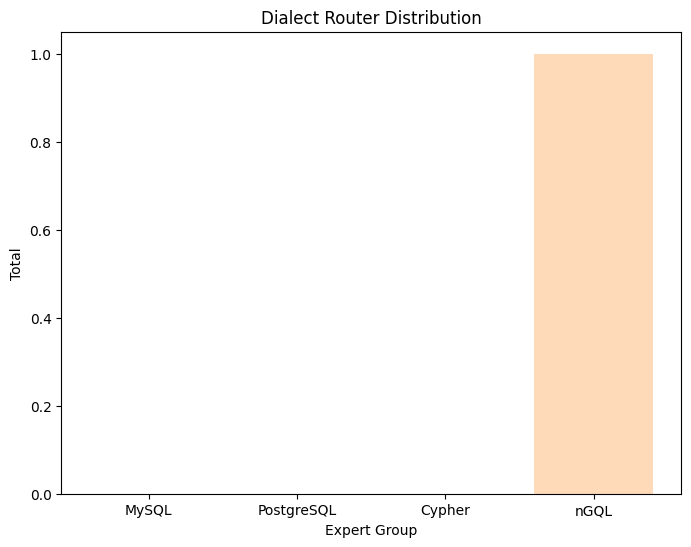

In [122]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt



dialect_logits = torch.load('dialect_logits_ng.pt', map_location=torch.device('cpu'))
expert_logits = torch.load('expert_logits_ng.pt', map_location=torch.device('cpu'))

# print(expert_logits.shape)
# loss_fct = CrossEntropyLoss()
# dialect_loss = loss_fct(mean_dialect_logits, dialect_labels)
# print(dialect_loss)




token_info = torch.mean(dialect_logits, dim=0)
token_info = F.softmax(token_info, dim=-1, dtype=torch.float)

# print(token_info.shape)
# print(token_info)
# print(token_info.shape)

weight = [0] * 4
for idx, token in enumerate(encoder_token_list):
    target = torch.argmax(token_info[idx], dim=-1).item()
    weight[target] += 1
    # print(token, torch.argmax(token_info[idx], dim=-1))
    # print(torch.argmax(token_info[idx], dim=-1))

weight = F.softmax(torch.Tensor(weight), dim=-1, dtype=torch.float)

colors = ['lightblue', 'lightgreen', 'lightcoral', 'peachpuff']

# Create the bar plot with the updated color palette
plt.figure(figsize=(8, 6))
plt.bar(range(len(weight)), weight, color=colors)

# plt.bar(range(token_info.shape[0]), token_info.numpy())

plt.xlabel('Expert Group')
plt.ylabel('Total')
plt.title('Dialect Router Distribution')
plt.xticks(range(len(weight)), ['MySQL', 'PostgreSQL', 'Cypher', 'nGQL'])
plt.show()


# dialect_weights = F.softmax(dialect_logits, dim=-1, dtype=torch.float)

# # print(torch.mean(dialect_weights, dim=0))

# expert_weights = F.softmax(expert_logits, dim=-1, dtype=torch.float)


# expert_weights = expert_weights.view(28, expert_weights.shape[1], 4, -1) * dialect_weights.unsqueeze(3)
# expert_weights = expert_weights.view(28, expert_weights.shape[1], -1)

# expert_weights, selected_experts = torch.topk(expert_weights, 2, dim=-1, sorted=False)

# selected_experts = selected_experts.view(-1, 2)
# test = [0] * 32
# for i in range(selected_experts.shape[0]):
    
#     # print(selected_experts.shape)
#     # print(selected_experts[i][0])
#     test[selected_experts[i][0].item()]+=1
#     test[selected_experts[i][1].item()]+=1



# # expert_weights = torch.mean(expert_weights[:,:,:], dim=0).mean(dim=0, dtype=torch.float)
# expert_weights = torch.mean(expert_weights, dim=0).mean(dim=0)
# # print(expert_weights.size())
# # 绘制柱状图
# plt.figure(figsize=(10, 6))
# # plt.bar(range(expert_weights.shape[0]), expert_weights.numpy())

# plt.bar(range(len(test)), test)
# plt.xlabel('Expert Index')
# plt.ylabel('Total Weight')
# plt.title('Expert Weight Distribution')
# plt.show()


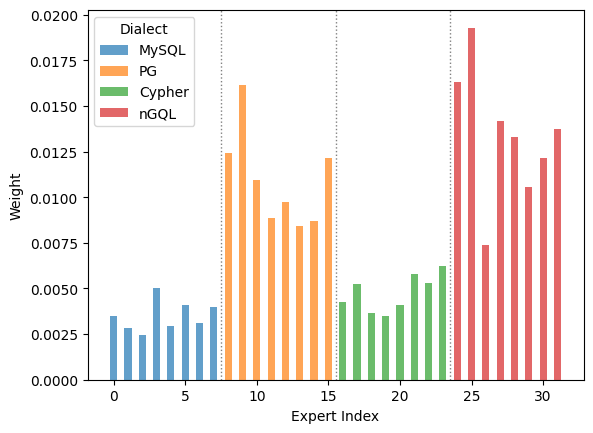

In [156]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt



dialect_logits = torch.load('dialect_logits_ng.pt', map_location=torch.device('cpu'))
expert_logits = torch.load('expert_logits_ng.pt', map_location=torch.device('cpu'))

# print(expert_logits.shape)
# loss_fct = CrossEntropyLoss()
# dialect_loss = loss_fct(mean_dialect_logits, dialect_labels)
# print(dialect_loss)



# token_info = torch.mean(dialect_logits, dim=0)
# token_info = F.softmax(token_info, dim=-1, dtype=torch.float)

# for idx, token in enumerate(encoder_token_list):
#     print(token, torch.argmax(token_info[idx], dim=-1))
#     print(torch.argmax(token_info[idx], dim=-1))

dialect_weights = F.softmax(dialect_logits, dim=-1, dtype=torch.float)

expert_weights = F.softmax(expert_logits, dim=-1, dtype=torch.float)


expert_weights = expert_weights.view(28, expert_weights.shape[1], 4, -1) * dialect_weights.unsqueeze(3)
expert_weights = expert_weights.view(28, expert_weights.shape[1], -1)




# expert_weights = torch.mean(expert_weights[:,:,:], dim=0).mean(dim=0, dtype=torch.float)
expert_weights = expert_weights[2].mean(dim=0)
# print(expert_weights.size())

# colors = ['b', 'g', 'r', 'orange']
colors = plt.cm.viridis([i / 32 for i in range(32)])  # Using the 'viridis' colormap for a visually appealing color set
# 绘制柱状图
# plt.figure(figsize=(10, 6))
bar_positions = range(32)
bar_width = 0.5
dialects = ['MySQL', 'PG', 'Cypher', 'nGQL']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
for i in range(0, 32, 8):
    plt.bar(bar_positions[i:i+8], expert_weights[i:i+8].numpy(), width=bar_width, label=dialects[i // 8], color=colors[i // 8], alpha=0.7)
# plt.bar(range(expert_weights.shape[0]), expert_weights.numpy())
# Adding dotted separators
for i in range(8, 32, 8):
    plt.axvline(x=i - 0.5, color='gray', linestyle=':', linewidth=1)
# plt.bar(range(len(test)), test)
plt.xlabel('Expert Index')
plt.ylabel('Weight')
plt.legend(title='Dialect')  # 添加图例
# plt.title('Expert Weight Distribution')
plt.savefig('expert_weight_distribution.pdf', format='pdf')

plt.show()




In [ ]:
import torch
dialect_logits = torch.randn(12, 777, 4).mean(dim=1)
select_group = torch.argmax(dialect_logits, dim=-1)

select_group = F.gumbel_softmax(dialect_logits, tau=1, hard=True, dim=-1).argmax(dim=-1)
print(select_group)

print(select_group.shape)
routing_weights = torch.randn(12, 4, 32)


mask = torch.zeros_like(routing_weights)
for idx, group in enumerate(select_group):
    start_idx = group * 8
    end_idx = start_idx + 8
    mask[idx, :, start_idx:end_idx] = 1

routing_weights = routing_weights * mask
print(routing_weights[0])

print(routing_weights[1])


print(len(routing_weights.shape))